<a href="https://colab.research.google.com/github/45-ak/CPS5004-Project/blob/Correlation-Analysis/CPS5004_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving AirQuality-Health-UK.csv to AirQuality-Health-UK (1).csv
(1825, 10)
['City', 'Date', 'PM2.5', 'NO2', 'O3', 'Temperature', 'Humidity', 'Hospital_Admissions', 'Population', 'Season']
         City        Date  PM2.5    NO2     O3  Temperature  Humidity  \
0      London  01/01/2023  14.85  29.55  30.31         9.18     86.21   
1  Manchester  01/01/2023  17.81  24.89  29.09         8.40     57.38   
2  Birmingham  01/01/2023  17.40  20.47  29.33        14.25     76.80   
3     Glasgow  01/01/2023  10.73  38.97  25.60        10.99     55.99   
4   Liverpool  01/01/2023   8.36  29.89  18.47        16.80     78.19   

   Hospital_Admissions  Population  Season  
0                   17      746103  Winter  
1                   14      534097  Winter  
2                    6      630659  Winter  
3                   12      830467  Winter  
4                   13      948429  Winter  


,Date,Month,Season
0,2023-01-01,1.0,Winter
1,2023-01-01,1.0,Winter
2,2023-01-01,1.0,Winter
3,2023-01-01,1.0,Winter
4,2023-01-01,1.0,Winter


Preprocessing completed. Rows remaining: 1825


,Date,PM2.5,NO2,O3,Temperature,Humidity,Hospital_Admissions,Population,Month,Season_Autumn,Season_Spring,Season_Summer,Season_Summper,Season_Winter,Season_nan,City_Birmingham,City_Glasgow,City_Liverpool,City_London,City_Manchester
0,2023-01-01,14.85,29.55,30.31,9.18,86.21,17,746103,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2023-01-01,17.81,24.89,29.09,8.40,57.38,14,534097,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2023-01-01,17.40,20.47,29.33,14.25,76.80,6,630659,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2023-01-01,10.73,38.97,25.60,10.99,55.99,12,830467,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2023-01-01,8.36,29.89,18.47,16.80,78.19,13,948429,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


Encoded columns: ['Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Summper', 'Season_Winter', 'Season_nan', 'City_Birmingham', 'City_Glasgow', 'City_Liverpool', 'City_London', 'City_Manchester']


,Pollution_Index,Temperature,Humidity,z_Pollution_Index,z_Temperature,z_Humidity,Admissions_per_100k
0,22.352,9.18,86.21,0.211357,-1.269187,1.478641,2.278506
1,22.190,8.40,57.38,0.171603,-1.332321,-0.511422,2.621247
2,20.707,14.25,76.80,-0.192314,-0.858813,0.829092,0.951386
3,22.176,10.99,55.99,0.168168,-1.122682,-0.607370,1.444970
4,16.841,16.80,78.19,-1.141000,-0.652411,0.925041,1.370688


Features complete


,Pollution_Index,Admissions_per_100k
count,1825.000000,1825.000000
mean,21.490699,1.932053
std,4.076224,0.761815
min,7.495040,0.309929
25%,18.729000,1.409694
50%,21.491000,1.820685
75%,24.191000,2.344023
max,33.805840,5.583914



Skewness:
 Pollution_Index       -0.017174
Admissions_per_100k    0.905420
dtype: float64


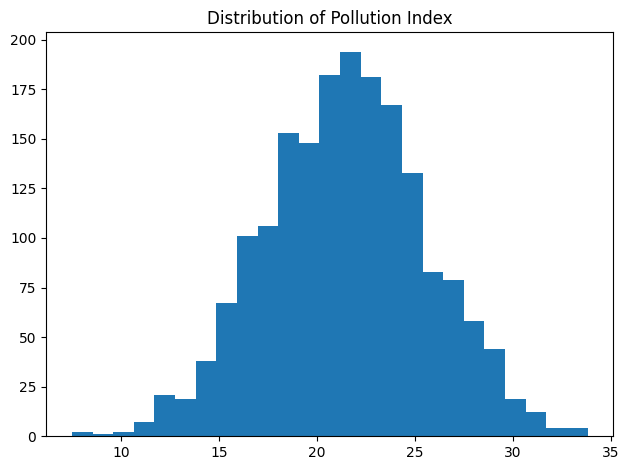

/tmp/ipython-input-594353087.py:134: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(season_groups, labels=season_order, showfliers=False)


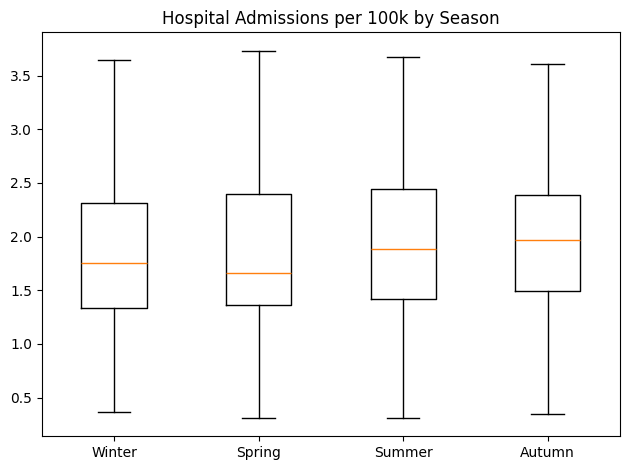

City comparison(pollution Index): London vs Manchester t=2.524, p=0.0118, n1365, n2=365

Season pairwise t-tests (Pollution Index): 
Winter vs Spring: t=0.984, p=0.326, n_a=240, n_b=120
Winter vs Summer: t=-0.773, p=0.44, n_a=240, n_b=120
Winter vs Autumn: t=-1.954, p=0.0514, n_a=240, n_b=180
Spring vs Summer: t=-1.484, p=0.139, n_a=120, n_b=120
Spring vs Autumn: t=-2.501, p=0.013, n_a=120, n_b=180
Summer vs Autumn: t=-0.854, p=0.394, n_a=120, n_b=180


,PM2.5,NO2,O3,Pollution_Index,Admissions_per_100k,Temperature,Humidity
PM2.5,1.000,0.018,-0.013,0.591,0.172,0.013,0.013
NO2,0.018,1.000,0.007,0.726,0.376,0.002,-0.003
O3,-0.013,0.007,1.000,0.370,0.299,-0.029,0.025
Pollution_Index,0.591,0.726,0.370,1.000,0.479,-0.002,0.015
Admissions_per_100k,0.172,0.376,0.299,0.479,1.000,-0.008,-0.026
Temperature,0.013,0.002,-0.029,-0.002,-0.008,1.000,0.052
Humidity,0.013,-0.003,0.025,0.015,-0.026,0.052,1.000


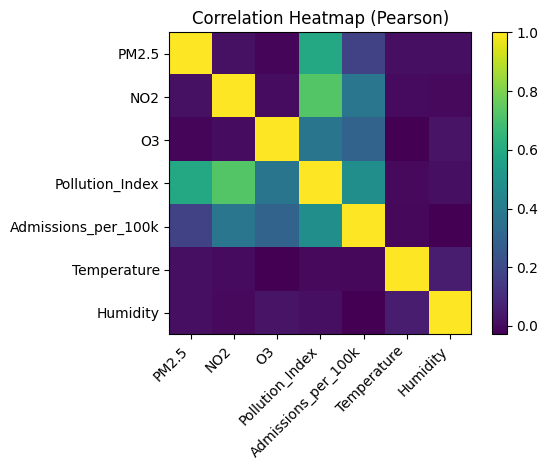

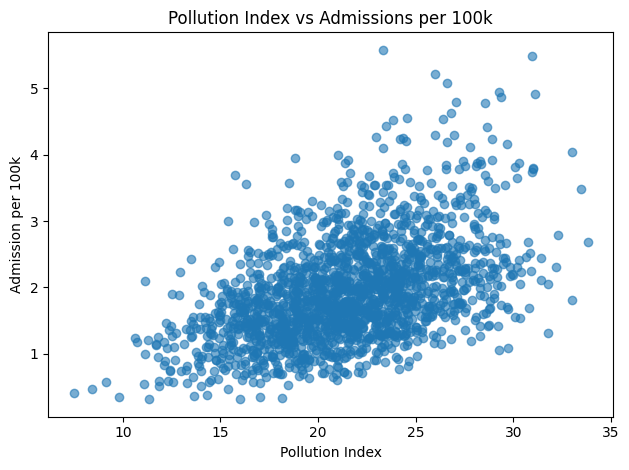

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Load the dataset
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('AirQuality-Health-UK.csv', header=0, sep=",")

print(df.shape)
print(df.columns.tolist())
print(df.head())

# Column Mapping Helper
CANDIDATES = {
    "date": ["Date", "date", "DATE"],
    "city": ["City", "city", "location", "Location"],
    "pm25": ["PM2.5", "PM25", "pm25"],
    "no2": ["NO2", "no2"],
    "o3": ["O3", "o3"],
    "temperature": ["Temperature", "temperature", "Temp", "temp"],
    "humidity": ["Humidity", "humidity"],
    "admissions": ["HospitalAdmissions", "Admissions", "admissions", "Hospital_Admissions"],
    "population": ["Population", "population",],

}

def pick_column(df, options, required=True):
  for col in options:
    if col in df.columns:
      return col
  if required:
    raise KeyError(f"None of the expected columns found: {options}")
  return None

COL = {k: pick_column(df, v, required=(k not in['temperature', 'humidity'])) for k, v in CANDIDATES.items()}
COL



# Describe the dataset

# Pre-Processing: Missing Values, Outliers, Datetime and season

# Remove rows where fields are missing
key_fields = [COL['date'], COL['city'], COL['pm25'], COL['no2'], COL['o3'], COL['admissions'], COL['population']]
df = df.dropna(subset=key_fields).copy()

# Optional fill temperature/humidity

# Outlier handling using z-score
for pollutant in [COL['pm25'], COL['no2'], COL['o3']]:
  z = np.abs(stats.zscore(df[pollutant].astype(float)))
  cap = df[pollutant][z < 4]
  lower, upper = cap.quantile(0.01), cap.quantile(0.99)
  df[pollutant] = df[pollutant].clip(lower, upper)

# Convert date to datetime
df[COL['date']] = pd.to_datetime(df[COL['date']], errors='coerce')

# Extracting month and season
df['Month'] = df[COL['date']].dt.month
SEASON_MAP ={12:'Winter', 1:'Winter', 2:'Winter',
             3:'Winter', 4:'Spring', 5:'Spring',
             6:'Summper', 7:'Summer', 8:'Summer',
             9:'Autumn', 10:'Autumn', 11:'Autumn' }
df['Season'] = df['Month'].map(SEASON_MAP)

display(df[[COL['date'], 'Month', 'Season']].head())
print("Preprocessing completed. Rows remaining:", len(df))


# Data Transformation - One-Hot Encoding
categorical = ['Season', COL['city']]
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop=None)
encoded = enc.fit_transform(df[categorical])
encoded_cols = enc.get_feature_names_out(categorical)
encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=df.index)

df_enc = pd.concat([df.drop(columns=categorical), encoded_df], axis=1)
display(df_enc.head())
print("Encoded columns:", list(encoded_cols))

# New features

# Pollution Index (wwighted average of PM2.5, NO2, O3)
df_enc['Pollution_Index'] = (0.5*df_enc[COL['pm25']] + 0.3*df_enc[COL['no2']] + 0.2*df_enc[COL['o3']]).astype(float)

# Admissions per 100k
df_enc['Admissions_per_100k'] = (df_enc[COL['admissions']].astype(float) / df_enc[COL['population']].astype(float)) * 100_000

# Standardise selected features
to_scale = ['Pollution_Index']
if COL.get('temperature') in df_enc.columns and COL.get('temperature') is not None:
  to_scale.append(COL['temperature'])
if COL.get('humidity') in df_enc.columns and COL.get('humidity') is not None:
  to_scale.append(COL['humidity'])

scaler = StandardScaler()
df_enc[[f"z_{c}" for c in to_scale]] = scaler.fit_transform(df_enc[to_scale])

display(df_enc[[*to_scale, *[f"z_{c}" for c in to_scale], 'Admissions_per_100k']].head())
print("Features complete")

# Descriptive Statistics and Visualisation

# Summary and skweness
stats_cols = ['Pollution_Index', 'Admissions_per_100k']
desc = df_enc[stats_cols].describe(include='all')
skew = df_enc[stats_cols].skew(numeric_only=True)
display(desc)
print("\nSkewness:\n", skew)


def show_title(title):
  plt.title(title)
  plt.tight_layout()
  plt.show()


# Histogram: Pollution Index
plt.figure()
plt.hist(df_enc['Pollution_Index'].dropna(), bins=25)
show_title('Distribution of Pollution Index')

# Box plot: Admissions as a fuction of Season
plt.figure()
# Data grouped by season
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
season_groups = [df_enc.loc[df['Season']==s, 'Admissions_per_100k'].dropna().values for s in season_order]
plt.boxplot(season_groups, labels=season_order, showfliers=False)
show_title('Hospital Admissions per 100k by Season')

# Inferential Statistics

# T-tests comparing the pollution index of two cities
city_counts = df[COL['city']].value_counts()
if len(city_counts) >= 2:
  c1, c2 = city_counts.index[0], city_counts.index[1]
  g1 = df_enc.loc[df[COL['city']] == c1, 'Pollution_Index'].dropna().values
  g2 = df_enc.loc[df[COL['city']] == c2, 'Pollution_Index'].dropna().values
  if len(g1) > 1 and len(g2) > 1:
    t_stat, p_val = stats.ttest_ind(g1, g2, equal_var=False, nan_policy='omit')
    print(f"City comparison(pollution Index): {c1} vs {c2} t={t_stat:.3f}, p={p_val:.3g}, n1{len(g1)}, n2={len(g2)}")
  else:
    print("Not enough data per city for t-test")
else:
  print("Fewer than 2 cites available for t-test")

# Pairwise independent t-tests across seasons
from itertools import combinations
season_labels = ['Winter', 'Spring', 'Summer', 'Autumn']
pairs = list(combinations(season_labels, 2))
print("\nSeason pairwise t-tests (Pollution Index): ")
for a, b in pairs:
  ga = df_enc.loc[df['Season'] == a, 'Pollution_Index'].dropna().values
  gb = df_enc.loc[df['Season'] == b, 'Pollution_Index'].dropna().values
  if len(ga) > 1 and len (gb) > 1:
    t_stat, p_val = stats.ttest_ind(ga, gb, equal_var=False, nan_policy='omit')
    print(f"{a} vs {b}: t={t_stat:.3f}, p={p_val:.3g}, n_a={len(ga)}, n_b={len(gb)}")
  else:
    print(f"{a} vs {b}: insufficient data for t-tests")

# Correlation Analysis Pollution Index vs Admissions
corr_cols = [COL['pm25'], COL['no2'], COL['o3'], 'Pollution_Index', 'Admissions_per_100k']
if COL.get('temperature') in df_enc.columns and COL.get('temperature') is not None:
  corr_cols.append(COL['temperature'])
if COL.get('humidity') in df_enc.columns and COL.get('humidity') is not None:
  corr_cols.append(COL['humidity'])

corr_df = df_enc[corr_cols].corr(method='pearson')
display(corr_df.round(3))

# Heatmap
plt.figure()
im = plt.imshow(corr_df, interpolation='nearest')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr_df.columns)), corr_df.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_df.index)), corr_df.index)
show_title('Correlation Heatmap (Pearson)')

# Scatter plot
plt.figure()
plt.scatter(df_enc['Pollution_Index'], df_enc['Admissions_per_100k'], alpha=0.6)
plt.xlabel('Pollution Index')
plt.ylabel('Admission per 100k')
show_title('Pollution Index vs Admissions per 100k')